In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from surprise import SVD, Dataset, Reader, KNNWithMeans, KNNBaseline

%matplotlib inline

# Load data

In [2]:
# read data
raw_data = pd.read_table('./data/ml-100k/u.data', header=None, 
                         names=['userId', 'itemId', 'rating', 'timestamp'])

raw_user = pd.read_table('./data/ml-100k/u.user', header=None, sep='|', 
                         names=['userId', 'age', 'gender', 'occupation', 'zipcode'])

raw_item = pd.read_table('./data/ml-100k/u.item', header=None, sep='|', engine='python',
                         names=['itemId', 'title', 'date', 'video date', 'URL', 'Unknown', 
                                'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                                'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                                'Thriller', 'War', 'Western'])

In [3]:
# read five folders for cross-validation
names = ['userId', 'itemId', 'rating', 'timestamp']
raw_u1_base = pd.read_table('./data/ml-100k/u1.base', header=None, names=names)
raw_u2_base = pd.read_table('./data/ml-100k/u2.base', header=None, names=names)
raw_u3_base = pd.read_table('./data/ml-100k/u3.base', header=None, names=names)
raw_u4_base = pd.read_table('./data/ml-100k/u4.base', header=None, names=names)
raw_u5_base = pd.read_table('./data/ml-100k/u5.base', header=None, names=names)

raw_u1_test = pd.read_table('./data/ml-100k/u1.test', header=None, names=names)
raw_u2_test = pd.read_table('./data/ml-100k/u2.test', header=None, names=names)
raw_u3_test = pd.read_table('./data/ml-100k/u3.test', header=None, names=names)
raw_u4_test = pd.read_table('./data/ml-100k/u4.test', header=None, names=names)
raw_u5_test = pd.read_table('./data/ml-100k/u5.test', header=None, names=names)

# Pre-processing

In [4]:
raw_data.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
raw_user.head()

,userId,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
raw_item.head()

,itemId,title,date,video date,URL,Unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
data = raw_data[['userId', 'itemId', 'rating']]
user = raw_user[['userId', 'age', 'gender']]
user.loc[:, 'gender'] = (user.loc[:, 'gender'] == 'M').astype(int)  # dummy encoding gender
item = raw_item[['itemId', 'Unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                 'Mystery', 'Romance', 'Sci-Fi',  'Thriller', 'War', 'Western']]

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
data.head()

,userId,itemId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [9]:
user.head()

,userId,age,gender
0,1,24,1
1,2,53,0
2,3,23,1
3,4,24,1
4,5,33,0


In [10]:
item.head()

,itemId,Unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [11]:
# merge useful information
tmp1 = raw_u1_base.merge(user, on='userId', how='left')
u1_base = tmp1.merge(item, on='itemId', how='left')

tmp2 = raw_u2_base.merge(user, on='userId', how='left')
u2_base = tmp2.merge(item, on='itemId', how='left')

tmp3 = raw_u3_base.merge(user, on='userId', how='left')
u3_base = tmp3.merge(item, on='itemId', how='left')

tmp4 = raw_u4_base.merge(user, on='userId', how='left')
u4_base = tmp4.merge(item, on='itemId', how='left')

tmp5 = raw_u5_base.merge(user, on='userId', how='left')
u5_base = tmp5.merge(item, on='itemId', how='left')

tmp1 = raw_u1_test.merge(user, on='userId', how='left')
u1_test = tmp1.merge(item, on='itemId', how='left')

tmp2 = raw_u2_test.merge(user, on='userId', how='left')
u2_test = tmp2.merge(item, on='itemId', how='left')

tmp3 = raw_u3_test.merge(user, on='userId', how='left')
u3_test = tmp3.merge(item, on='itemId', how='left')

tmp4 = raw_u4_test.merge(user, on='userId', how='left')
u4_test = tmp4.merge(item, on='itemId', how='left')

tmp5 = raw_u5_test.merge(user, on='userId', how='left')
u5_test = tmp5.merge(item, on='itemId', how='left')

# form list for convenience
train_data = [u1_base, u2_base, u3_base, u4_base, u5_base]
test_data = [u1_test, u2_test, u3_test, u4_test, u5_test]

# Part a: Build Model and 5-Folder Cross-Validation

## Model 1: Linear Regression

In [12]:
# features to be used
x_names = ['age', 'gender', 'Unknown', 'Action', 'Adventure', 'Animation', 'Children', 
           'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

linear_train_rmse = []
linear_test_rmse = []
for train, test in zip(train_data, test_data):
    train_x = train[x_names].values
    train_y = train['rating'].values
    test_x = test[x_names].values
    test_y = test['rating'].values
    
    # build the model
    regress = linear_model.LinearRegression()
    regress.fit(train_x, train_y)
    
    # make prediction
    train_pred = regress.predict(train_x)
    test_pred = regress.predict(test_x)
    
    # calculate RMSE
    linear_train_rmse.append(np.sqrt(mean_squared_error(train_y, train_pred)))
    linear_test_rmse.append(np.sqrt(mean_squared_error(test_y, test_pred)))

print('Train RMSE:\t', *linear_train_rmse)
print('mean:\t\t', np.mean(linear_train_rmse))
print('std:\t\t', np.std(linear_train_rmse))

print('\nTest RMSE\t', *linear_test_rmse)
print('mean:\t\t', np.mean(linear_test_rmse))
print('std:\t\t', np.std(linear_test_rmse))

Train RMSE:	 1.101123128775863 1.1061160739884612 1.1103858207922974 1.110475513704052 1.1094860744895474
mean:		 1.107517322350044
std:		 0.0035694361689733107

Test RMSE	 1.133321994065045 1.1135238760927997 1.0964510879987863 1.0959787554994986 1.0999735296568491
mean:		 1.1078498486625958
std:		 0.014240195064115148


## Model 2: Surprise KNN Model

In [13]:
knn_train_rmse = []
knn_test_rmse = []

for train, test in zip(train_data, test_data):
    # create data set
    reader = Reader(rating_scale=(1, 5))
    train_tmp = Dataset.load_from_df(train[['userId', 'itemId', 'rating']], reader)
    train_set = train_tmp.build_full_trainset()
    
    # define parameters
    sim_options = {'name': 'msd',
                   'user_based': False,
                   'shrinkage': 10}

    # build the algorithm
    knn = KNNWithMeans(k=10, min_k=1, sim_options=sim_options)
    knn.fit(train_set)

    # make predictions
    train_pred = []
    test_pred = []
    train_uid = list(map(str, train['userId']))
    train_iid = list(map(str, train['itemId']))
    for uid, iid in zip(train_uid, train_iid):
        train_pred.append(knn.predict(uid, iid).est)
        
    test_uid = list(map(str, test['userId']))
    test_iid = list(map(str, test['itemId']))
    for uid, iid in zip(test_uid, test_iid):
        test_pred.append(knn.predict(uid, iid).est)
    
    # calculate RMSE
    knn_train_rmse.append(np.sqrt(mean_squared_error(train['rating'].values, train_pred)))
    knn_test_rmse.append(np.sqrt(mean_squared_error(test['rating'].values, test_pred)))

print('Train RMSE:\t', *knn_train_rmse)
print('mean:\t\t', np.mean(knn_train_rmse))
print('std:\t\t', np.std(knn_train_rmse))

print('\nTest RMSE:\t', *knn_test_rmse)
print('mean:\t\t', np.mean(knn_test_rmse))
print('std:\t\t', np.std(knn_test_rmse))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Train RMSE:	 1.1185576773237935 1.1244219564263898 1.1291627727408262 1.128742566351491 1.1274109215781751
mean:		 1.125659178884135
std:		 0.003919517686504215

Test RMSE:	 1.1536759477860323 1.1306638194690102 1.111582280538085 1.1132936843691559 1.1186753003692582
mean:		 1.1255782065063085
std:		 0.015555012473230656


# Part b: Visualization

In [14]:
# merge all data
tmp = data.merge(user, on='userId', how='left')
matrix = tmp.merge(item, on='itemId', how='left')

# create user-item utility matrix
user_ids = sorted(matrix['userId'].unique())
item_ids = sorted(matrix['itemId'].unique())

utility = np.zeros((len(user_ids), len(item_ids)))
for uid, iid, rating in zip(matrix['userId'].values, matrix['itemId'].values, matrix['rating'].values):
    utility[uid - 1, iid - 1] = rating

# group user-item matrix
user_rating_count = matrix[['userId', 'rating']].groupby('userId').count()
item_rating_count = matrix[['itemId', 'rating']].groupby('itemId').count()
user_rating_mean = matrix[['userId', 'rating']].groupby('userId').mean()
item_rating_mean = matrix[['itemId', 'rating']].groupby('itemId').mean()

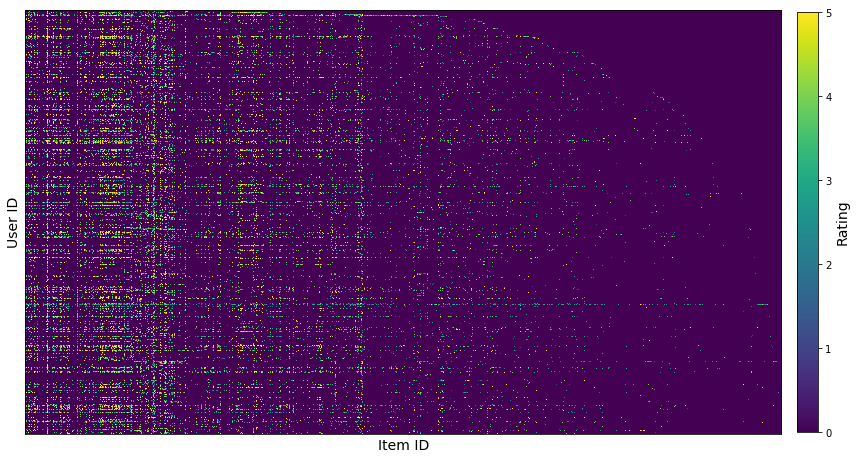

In [15]:
# visualize the utility matrix
fig, ax = plt.subplots(figsize=(12, 8))
img = plt.imshow(utility)
ax.axis('image')
ax.set_xlabel('Item ID', fontsize=14)
ax.set_xticks([])
ax.set_ylabel('User ID', fontsize=14)
ax.set_yticks([])
cbar = fig.colorbar(img, fraction=0.0265, pad=0.02)
cbar.ax.set_ylabel('Rating', fontsize=14)
plt.tight_layout()
fig.savefig('./result/utility.png', dpi=200)
fig.savefig('./result/utility.pdf')
plt.show()

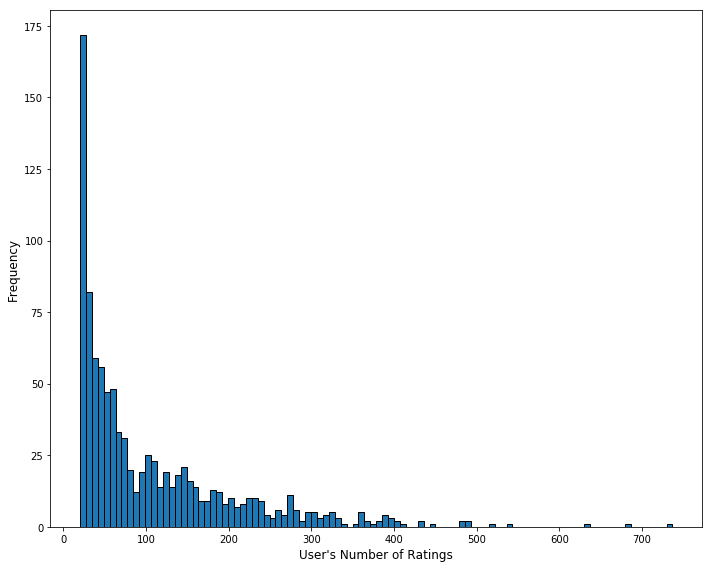

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(user_rating_count['rating'], bins=100, edgecolor='black')
ax.set_xlabel("User's Number of Ratings", fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
fig.savefig('./result/user_frequency.png', dpi=200)
fig.savefig('./result/user_frequency.pdf')
plt.show()

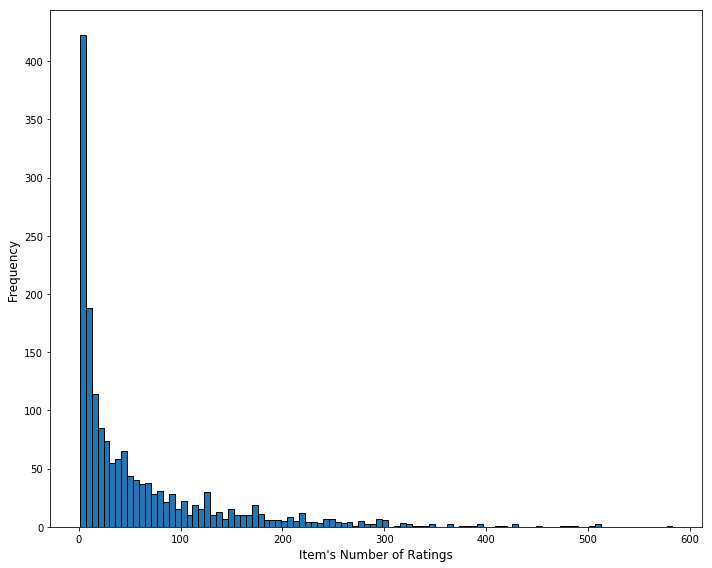

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(item_rating_count['rating'], bins=100, edgecolor='black')
ax.set_xlabel("Item's Number of Ratings", fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
fig.savefig('./result/item_frequency.png', dpi=200)
fig.savefig('./result/item_frequency.pdf')
plt.show()

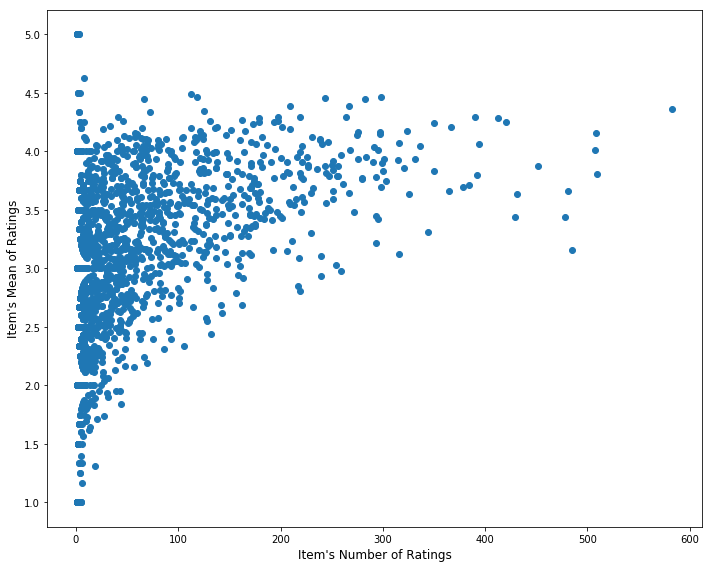

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(item_rating_count['rating'], item_rating_mean['rating'])
ax.set_xlabel("Item's Number of Ratings", fontsize=12)
ax.set_ylabel("Item's Mean of Ratings", fontsize=12)
plt.tight_layout()
fig.savefig('./result/item_mean_rating.png', dpi=200)
fig.savefig('./result/item_mean_rating.pdf')
plt.show()

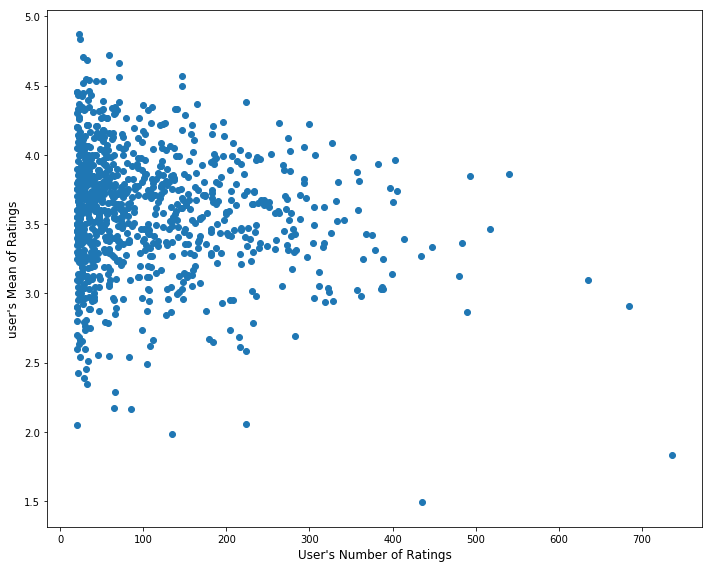

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(user_rating_count['rating'], user_rating_mean['rating'])
ax.set_xlabel("User's Number of Ratings", fontsize=12)
ax.set_ylabel("user's Mean of Ratings", fontsize=12)
plt.tight_layout()
fig.savefig('./result/user_mean_rating.png', dpi=200)
fig.savefig('./result/user_mean_rating.pdf')
plt.show()

# Part c: Re-build Model

## Linear regression of rating on number of rating

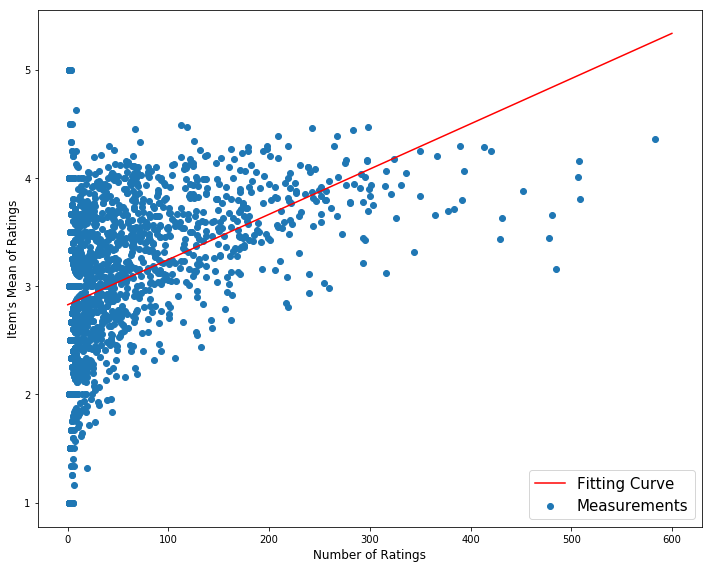

In [20]:
x = item_rating_count['rating'].values
y = item_rating_mean['rating'].values

# build the model
regress = linear_model.LinearRegression()
regress = regress.fit(x[:, np.newaxis], y)

# make predictions
num = np.arange(0, 601)
mean = regress.predict(num[:, np.newaxis])

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(item_rating_count['rating'], item_rating_mean['rating'], label='Measurements')
ax.plot(num, mean, label='Fitting Curve', c='r')
ax.legend(fontsize=15, loc=4)
ax.set_xlabel('Number of Ratings', fontsize=12)
ax.set_ylabel("Item's Mean of Ratings", fontsize=12)
plt.tight_layout()
fig.savefig('./result/fitting_curve.png', dpi=200)
fig.savefig('./result/fitting_curve.pdf')
plt.show()

## Linear Regression

In [21]:
# make prediction on the whole data set
mean_prediction = regress.predict(x[:, np.newaxis])
popularity = pd.DataFrame({'itemId': item_rating_mean.index, 'mean': mean_prediction})

In [22]:
# features to be used
x_names = ['age', 'gender', 'Unknown', 'Action', 'Adventure', 'Animation', 'Children', 
           'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'mean']

linear_train_rmse = []
linear_test_rmse = []
for train, test in zip(train_data, test_data):
    train = train.merge(popularity, on='itemId', how='left')
    test = test.merge(popularity, on='itemId', how='left')
    train_x = train[x_names].values
    train_y = train['rating'].values
    test_x = test[x_names].values
    test_y = test['rating'].values
    
    # build the model
    regress = linear_model.LinearRegression()
    regress.fit(train_x, train_y)
    
    # make prediction
    train_pred = regress.predict(train_x)
    test_pred = regress.predict(test_x)
    
    # calculate RMSE
    linear_train_rmse.append(np.sqrt(mean_squared_error(train_y, train_pred)))
    linear_test_rmse.append(np.sqrt(mean_squared_error(test_y, test_pred)))

print('Train RMSE:\t', *linear_train_rmse)
print('mean:\t\t', np.mean(linear_train_rmse))
print('std:\t\t', np.std(linear_train_rmse))

print('\nTest RMSE\t', *linear_test_rmse)
print('mean:\t\t', np.mean(linear_test_rmse))
print('std:\t\t', np.std(linear_test_rmse))

Train RMSE:	 1.0768870230885361 1.0810644846881008 1.0839998658171552 1.0850823723717409 1.083555262270508
mean:		 1.0821178016472082
std:		 0.0029280593952411204

Test RMSE	 1.103477084121278 1.0867440406925133 1.0750537794947697 1.0705949748548327 1.076741759719872
mean:		 1.0825223277766531
std:		 0.011733546792220134


## Model 2: Surprise KNN Model

In [23]:
knn_train_rmse = []
knn_test_rmse = []

for train, test in zip(train_data, test_data):
    # create data set
    reader = Reader(rating_scale=(1, 5))
    train_tmp = Dataset.load_from_df(train[['userId', 'itemId', 'rating']], reader)
    train_set = train_tmp.build_full_trainset()
    
    # define parameters
    sim_options = {'name': 'msd',
                   'user_based': False,
                   'shrinkage': 10}

    # build the algorithm
    knn = KNNWithMeans(k=10, min_k=1, sim_options=sim_options)
    knn.fit(train_set)

    # make predictions
    train_pred = []
    test_pred = []
    train_uid = list(map(str, train['userId']))
    train_iid = list(map(str, train['itemId']))
    for uid, iid in zip(train_uid, train_iid):
        train_pred.append(knn.predict(uid, iid).est)
        
    test_uid = list(map(str, test['userId']))
    test_iid = list(map(str, test['itemId']))
    for uid, iid in zip(test_uid, test_iid):
        test_pred.append(knn.predict(uid, iid).est)
        
    # merge with popularity
    tmp_train = pd.DataFrame({'itemId': train['itemId'].values, 'pred': train_pred})
    tmp_test = pd.DataFrame({'itemId': test['itemId'].values, 'pred': test_pred})
    tmp_train = tmp_train.merge(popularity, on='itemId', how='left')
    tmp_test = tmp_test.merge(popularity, on='itemId', how='left')
    
    # compute average
    train_pred = (tmp_train['pred'].values + tmp_train['mean'].values) / 2.0
    test_pred = (tmp_test['pred'].values + tmp_test['mean'].values) / 2.0
    
    # calculate RMSE
    knn_train_rmse.append(np.sqrt(mean_squared_error(train['rating'].values, train_pred)))
    knn_test_rmse.append(np.sqrt(mean_squared_error(test['rating'].values, test_pred)))

print('Train RMSE:\t', *knn_train_rmse)
print('mean:\t\t', np.mean(knn_train_rmse))
print('std:\t\t', np.std(knn_train_rmse))

print('\nTest RMSE:\t', *knn_test_rmse)
print('mean:\t\t', np.mean(knn_test_rmse))
print('std:\t\t', np.std(knn_test_rmse))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Train RMSE:	 1.092580263419305 1.0975860141657738 1.10118231539574 1.1017946749792589 1.0998061041359022
mean:		 1.098589874419196
std:		 0.0033344826090071595

Test RMSE:	 1.1223441819117406 1.102639712412127 1.0881966996291375 1.0857159526583995 1.093750333179001
mean:		 1.0985293759580812
std:		 0.013250110301697312
